In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import os
from pathlib import Path 
import matplotlib.pyplot as plt
import rasterio
from fastai.vision.all import *
import skimage.io as skio
import torch
from torch.utils.data import Dataset
import cv2
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Dataset Class

In [47]:
class S2Disease(Dataset):
    def __init__(self, root_dir, is_eval=False, transform=None):
        """
        Args:
            root_dir (str): rootman
            is_eval (bool): If True, loads only from 'evaluation'. If False, loads diseases.
            transform (callable, optional): PyTorch transforms.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.is_eval = is_eval
        
        self.bands = [
            'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 
            'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'
        ]

        # Create a mapping from band name to index for plotting
        self.band_to_idx = {name: i for i, name in enumerate(self.bands)}
        
        if is_eval:
            self.samples = list((self.root_dir / "evaluation").glob("*/"))
            # We still need the class list to know the vector size for one-hot encoding
            # assuming the structure is consistent. 
            # Ideally, pass the class list from the training set.
            self.classes = ['Aphid', 'Blast', 'RPH', 'Rust'] 
            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        else:
            all_dirs = [d for d in self.root_dir.iterdir() if d.is_dir()]
            self.classes = sorted([d.name for d in all_dirs if d.name != "evaluation"])
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
            self.samples = []
            for cls in self.classes:
                self.samples.extend(list((self.root_dir / cls).glob("*/")))
                
        self.num_classes = len(self.classes)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = self.samples[idx]

        ## target size
        target_size = (264, 264)
        
        # Load spectral bands
        band_data = []
        for band in self.bands:
            band_file = sample_path / f"{band}.tif"
            with rasterio.open(band_file) as src:
                data = src.read(1).astype(np.float32)
                
                # Check if resize is needed
                if data.shape != target_size:
                    # cv2.resize expects (width, height), which is (columns, rows)
                    data = cv2.resize(data, target_size, interpolation=cv2.INTER_LINEAR)
                
                band_data.append(data)
        
        # Stack into (Channels, Height, Width)
        image = np.stack(band_data)
        
        # Determine Label
        if self.is_eval:
            # For evaluation, return a dummy zero vector of the same shape
            one_hot_label = torch.zeros(self.num_classes)
        else:
            class_name = sample_path.parent.name
            label_idx = self.class_to_idx[class_name]
            # Create one-hot vector: [1, 0, 0, 0]
            one_hot_label = torch.zeros(self.num_classes)
            one_hot_label[label_idx] = 1.0
        
        sample = {
            'image': torch.from_numpy(image),
            'label': one_hot_label,
            'sample_id': sample_path.name # Useful for Kaggle submission tracking
        }

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

    def plot(self, 
             sample: dict, 
             bands: list[str] = ['B4', 'B3', 'B2'], 
             figsize: tuple = (8, 8),
             suptitle: str = None) -> Figure:
            """
            Plots chosen bands. If 3 bands provided, plots RGB. If 1, plots grayscale.
            """
            img_tensor = sample['image']
            plot_data = []
    
            #index mapping
            for b in bands:
                idx = self.band_to_idx[b]
                band_array = img_tensor[idx].numpy()
                
                # clip to the 2nd and 98th percentile
                vmin, vmax = np.percentile(band_array, (2, 98))
                band_array = np.clip((band_array - vmin) / (vmax - vmin + 1e-8), 0, 1)
                plot_data.append(band_array)

            fig, ax = plt.subplots(figsize=figsize)
    
            if len(bands) == 3:
                # (H, W, 3) for RGB
                rgb_img = np.stack(plot_data, axis=-1)
                ax.imshow(rgb_img)
                ax.set_title(f"RGB Composite: {bands}")
            else:
                # Plot single band (grayscale)
                ax.imshow(plot_data[0], cmap='gray')
                ax.set_title(f"Single Band: {bands[0]}")
    
            ax.axis('off')
            
            if suptitle:
                plt.suptitle(suptitle)
            elif not self.is_eval:
                class_name = [k for k, v in self.class_to_idx.items() if v == sample['label']][0]
                plt.suptitle(f"Class: {class_name} | ID: {sample['sample_id']}")
    
            return fig

### create the dataset class object

In [48]:
dataset = S2Disease( root_dir = "/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle")

In [49]:
dataset.__getitem__(1)['label']

tensor([1., 0., 0., 0.])

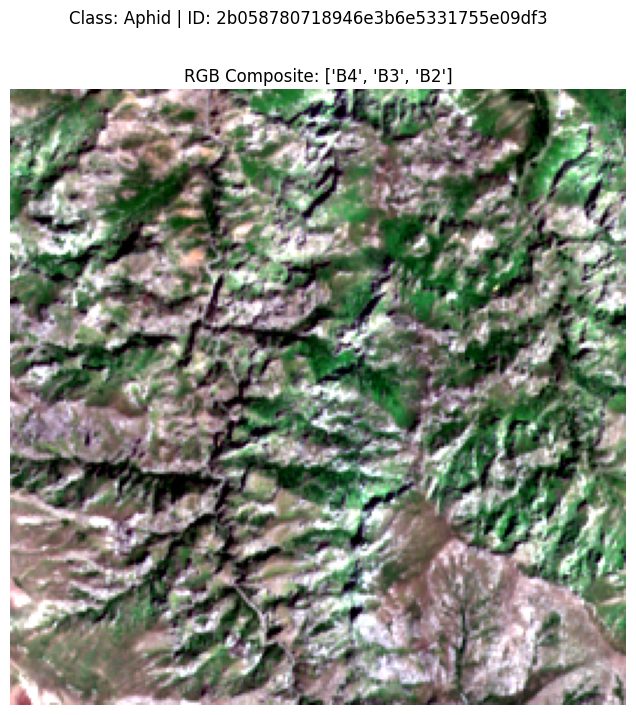

In [39]:
fig = dataset.plot(dataset.__getitem__(12))

## DataModule Class

In [41]:
class S2DiseaseDataModule(pl.LightningDataModule):
    def __init__(
        self,
        root_dir: str,
        batch_size: int = 16,
        num_workers: int = 4,
        train_val_test_split: tuple[float, float, float] = (0.8, 0.1, 0.1),
        transforms: Optional[Callable] = None,
        seed: int = 42,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_val_test_split = train_val_test_split
        self.transforms = transforms
        self.seed = seed

        # Datasets placeholders
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.predict_dataset = None

    def setup(self, stage: Optional[str] = None):
        """Set up datasets based on the stage (fit, test, predict)."""

        if stage == "fit" or stage == "test" or stage is None:
            # Load the main labeled dataset (Aphid, Blast, RPH, Rust)
            full_dataset = S2Disease(
                root_dir=self.root_dir,
                is_eval=False,
                transform=self.transforms
            )

            # Split logic
            total_size = len(full_dataset)
            train_size = int(self.train_val_test_split[0] * total_size)
            val_size = int(self.train_val_test_split[1] * total_size)
            test_size = total_size - train_size - val_size

            generator = torch.Generator().manual_seed(self.seed)
            self.train_dataset, self.val_dataset, self.test_dataset = random_split(
                full_dataset,
                [train_size, val_size, test_size],
                generator=generator
            )

        if stage == "predict":
            # Load from the 'evaluation' folder
            self.predict_dataset = S2Disease(
                root_dir=self.root_dir,
                is_eval=True,
                transform=self.transforms
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )